# Customer Segmentation (K-Means Clustering)

At the core of customer segmentation is being able to identify different types of customers and then figure out ways to find more of those individuals so you can get more customers. In this tutorial, we will learn how you can use K-Means clustering to help with some of the exploratory aspects of customer segmentation.

** Dataset Information **

The data we're using comes from John Foreman's book Data Smart. The dataset contains both information on marketing newsletters/e-mail campaigns (e-mail offers sent) and transaction level data from customers (which offer customers responded to and what they bought).

In [1]:
import pandas as pd

df_offers = pd.read_excel("WineKMC.xlsx", sheetname=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


Let's look at the transaction level data.

In [2]:
df_transactions = pd.read_excel("WineKMC.xlsx", sheetname=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


In order to segment our customers, we need a way to compare them. To do this we're going to use K-Means clustering. K-means is a way of taking a dataset and finding groups (or clusters) of points that have similar properties. K-means works by grouping the points together in such a way that the distance between all the points and the midpoint of the cluster they belong to is minimized.

** Clustering our customers **

Okay, so how does clustering apply to our customers? Well since we're trying to learn more about how our customers behave, we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

In [3]:
# join the offers and transactions table
df = pd.merge(df_offers, df_transactions)
df.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak,customer_name,n
0,1,January,Malbec,72,56,France,False,Thomas,1
1,1,January,Malbec,72,56,France,False,Jackson,1
2,1,January,Malbec,72,56,France,False,Mitchell,1
3,1,January,Malbec,72,56,France,False,Peterson,1
4,1,January,Malbec,72,56,France,False,Wood,1


In [4]:
# create a "pivot table" which will give us the number of times each customer responded to a given offer
matrix = df.pivot_table(index=['customer_name'], columns=['offer_id'], values='n')
matrix.head()

offer_id,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
customer_name,,,,,,,,,,,,,,,,,,,,,
Adams,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN
Allen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
Anderson,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
Bailey,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
Baker,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN


In [5]:
# a little tidying up. fill NaN values with 0 and make the index into a column
matrix = matrix.fillna(0).reset_index()
matrix.head()

offer_id,customer_name,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,Adams,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,Allen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,Anderson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bailey,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,Baker,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Save a list of the 0/1 columns. we'll use these a bit later

In [6]:
x_cols = matrix.columns[1:]
x_cols

Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32],
      dtype='object', name='offer_id')

Now to create the clusters, we're going to use the KMeans functionality from scikit-learn. 

*inertia_ : Sum of distances of samples to their closest cluster center.*

**Find optimal K-value**

In [7]:
from sklearn.cluster import KMeans

n = int(input("Enter Starting Cluster: "))
n1 = int(input("Enter Ending Cluster: "))
for i in range(n,n1):
    km = KMeans(n_clusters=i)
    km.fit(matrix[matrix.columns[2:]])
    print (i, km.inertia_)

Enter Starting Cluster: 1
Enter Ending Cluster: 20
1 272.9
2 243.093333333
3 219.272959184
4 206.109343434
5 194.333571133
6 188.059615385
7 179.294684945
8 170.160396825
9 168.221572872
10 160.500420168
11 153.951501035
12 144.526587302
13 142.866666667
14 140.865587045
15 131.639646465
16 126.950396825
17 127.024603175
18 121.596212121
19 118.343253968


As the k-value increases, the drop in number diminishes, which means the new result is not that much better than the earlier result. For example, if cluster 5 is where the changes in values start slowing down, k=5 is what I am look for.

In [33]:
from sklearn.cluster import KMeans

cluster = KMeans(n_clusters=5, init='k-means++', n_init=10, random_state = 1)

# slice matrix so we only include the 0/1 indicator columns in the clustering
matrix['cluster'] = cluster.fit_predict(matrix[matrix.columns[2:]])
matrix.cluster.value_counts()

1    33
4    26
3    14
0    14
2    13
Name: cluster, dtype: int64

** Visualizing the cluster **

We're going to use PCA to transform our multi-dimensional dataset into a 2 dimensional dataset. The rationale is once it is in 2 dimensions (or simply put, it has 2 columns), it becomes much easier to plot.

In [112]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
matrix['x'] = pca.fit_transform(matrix[x_cols])[:,0]
matrix['y'] = pca.fit_transform(matrix[x_cols])[:,1]
matrix = matrix.reset_index()

customer_clusters = matrix[['customer_name', 'cluster', 'x', 'y']]
customer_clusters.head()

offer_id,customer_name,cluster,x,y
0,Adams,3,1.007580,0.108215
1,Allen,0,-0.287539,0.044715
2,Anderson,4,-0.392032,1.038391
3,Bailey,3,0.699477,-0.022542
4,Baker,1,0.088183,-0.471695


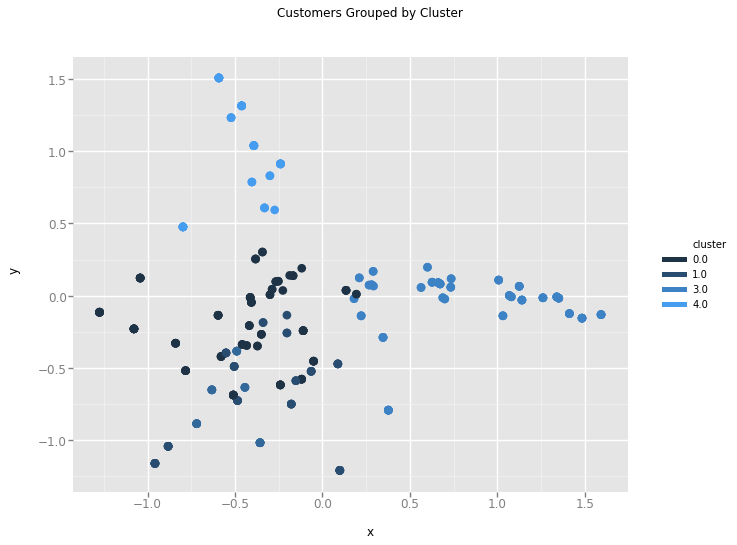

<ggplot: (-9223371898339183584)>

In [113]:
df = pd.merge(df_transactions, customer_clusters)
df = pd.merge(df_offers, df)

from ggplot import *

ggplot(df, aes(x='x', y='y', colour ='cluster')) + \
    geom_point(size=75) + \
    ggtitle("Customers Grouped by Cluster")     

** Digging deeper into the clusters **

Let's dig a little deeper into the clusters. Take cluster 4 for example. If we break out cluster 4 and compare it to the remaining customers, we can start to look for interesting facets that we might be able to exploit.

As a baseline, take a look at the varietal counts for cluster 4 vs. everyone else. It turns out that almost all of the Champagne offers were purchased by members outside of cluster 4. In addition, none of the Espumante offers were purchased by members of cluster 4.

In [115]:
df['is_4'] = df.cluster==4
df.groupby("is_4").varietal.value_counts()

is_4   varietal          
False  Champagne             80
       Prosecco              41
       Espumante             40
       Cabernet Sauvignon    32
       Malbec                31
       Merlot                19
       Pinot Grigio          17
       Chardonnay            14
       Pinot Noir             7
True   Pinot Noir            37
       Prosecco               2
       Champagne              1
       Chardonnay             1
       Malbec                 1
       Merlot                 1
Name: varietal, dtype: int64

You can also segment out numerical features. For instance, look at how the mean of the min_qty field breaks out between 4 vs. non-4. It seems like members of cluster 4 like to by in bulk!

In [116]:
df.groupby("is_4")[['min_qty', 'discount']].mean()

,min_qty,discount
is_4,,
False,57.309609,60.608541
True,65.581395,52.116279
